#Statistical learning – Final project

In this project, I am going to investigate error bound for LDA classification algorythm. According to fundamental theorem of statistical learning [Shalev-Shwartz and Ben-David, 2014, Theorem 6.8, item 3]:

THEOREM 6.8 (The Fundamental Theorem of Statistical Learning — Quantita-tive Version) Let $\mathcal{H}$ be a hypothesis class of functions from a domain $X$ to $\{0, 1\}$ and let the loss function be the 0 — 1 loss. Assume that $VCdim(\mathcal{H}) = d < \infty$. Then, there are absolute constants $C_1$, $C_2$ such that model is PAC learnable with sample complexity 

$$C_1 \frac{d + \log{(1/ \delta)}}{\epsilon} \leq m_H(\epsilon, \delta) \leq C_2 \frac{d\log{(1/\epsilon)} + \log{(1/\delta)}}{\epsilon}$$

where $\epsilon>0$ and $\delta \in (0,1)$. 

Accordin to Corollary 2.3, $1-\delta$  s a probability that over the choice of an i.i.d. sample $S$ of size $m$, we have that for every ERM hypothesis, $h_s$, it holds that $$L_{(D,f)}\leq \epsilon$$ [Shalev-Shwartz and Ben-David, 2014, Corollary 2.3]




This theorem, should work for LDA if assumptions about $\mathcal{D}$ are met [Shalev-Shwartz and Ben-David, 2014, Section: 24.3 Linear Discriminant Analysis]
:
1. First, we assume that $P[Y = 1] = P[Y = 0] = 1/2$. 
2. Second, we assume that the conditional probability of $X$ given $Y$ is a Gaussian distribution.
3. Finally, the covariance matrix of the Gaussian distribution is the same for both values of the label.


Before proceeding to the project, we need to import all needed libraries.

In [1]:
#essential ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
         'axes.labelsize': 14,
         'axes.titlesize':20
         }

pylab.rcParams.update(params)

#selected model for research
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#model needed to estimate boundary
from sklearn.linear_model import LinearRegression

#data preprocessing, training and evaluating
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


#Generate data

By assumtions about $\mathcal{D}$ for LDA, we would like that our data is Gaussian distributed with the same covariance matrices and classes are balanced.

At first, lets try to create two classes with number of features $d=5$ and $60$ samples per each class.

In [2]:
d = 5 #number of features
N = 60 #number of samples per class

Covariance matrix for two classes should be the same, positive-semidefinite (it should have a root) and symmetric.

In [3]:
b = np.random.random(size = (d,d))
cov = (b + b.T)/2
cov = cov @ cov.T
cov

array([[1.23198786, 1.48245243, 1.40324775, 1.45027044, 1.3096093 ],
       [1.48245243, 2.55871421, 2.17993307, 2.30076485, 1.40920403],
       [1.40324775, 2.17993307, 1.91480774, 2.01992433, 1.40494916],
       [1.45027044, 2.30076485, 2.01992433, 2.55372933, 1.64424571],
       [1.3096093 , 1.40920403, 1.40494916, 1.64424571, 1.62669367]])

By assumtion, there is no limitation on means of two classes, thus I will generate $\mu_0, \mu_1 \in \mathbb{R}^d$, where $d$ is number of features. I will generate them randomly, using ```np.random.random```, which return value $x\in(0,1)$ from uniform distribution.



In [4]:
means_class_0 = np.random.random(d)
means_class_1 = np.random.random(d)

Generate features according to gaussian distribution with set covariance and means (N samples for each class).

In [5]:
x_class_0 = np.random.multivariate_normal(means_class_0, cov, N).T
x_class_1 = np.random.multivariate_normal(means_class_1, cov, N).T 

Graphically visualise all features:

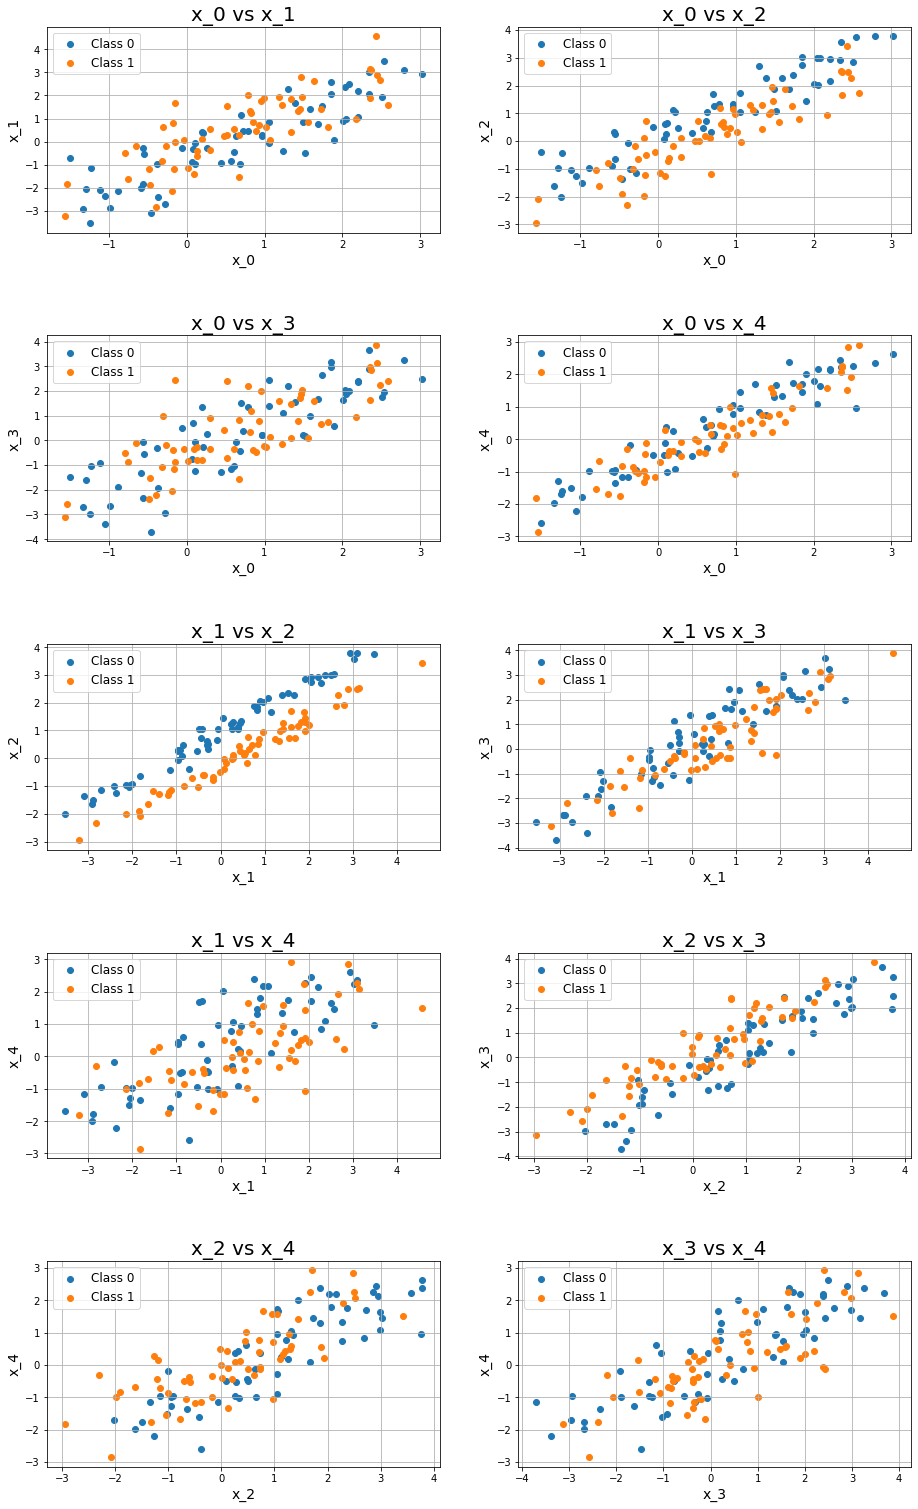

In [6]:
data = []
class_names = []

#get all possible pairings of features for class 0 and 1
for i in range(d-1):
    for j in range(i+1,d):

        data.append([[x_class_0[i], x_class_0[j]], [x_class_1[i], x_class_1[j]]])
        class_names.append((i,j))

data = np.array(data)

fig, axs = plt.subplots(d, 2, figsize=(15, 25))
counter = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        #scatter plot data-point of class 0
        x0, y0 = data[counter][0]
        axs[i,j].scatter(x0, y0, label = "Class 0")

        #scatter plot data-point of class 1
        x1, y1 = data[counter][1]
        axs[i,j].scatter(x1, y1, label = "Class 1")

        #graph settings
        axs[i,j].set_xlabel(f"x_{class_names[counter][0]}")
        axs[i,j].set_ylabel(f"x_{class_names[counter][1]}")
        axs[i,j].set_title(f"x_{class_names[counter][0]} vs x_{class_names[counter][1]}")
        axs[i,j].legend()
        axs[i,j].grid()

        counter+=1

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

plt.show()

The only thing left is to generate labels and combine data about classes into one dataset.

In [7]:
data = np.hstack((x_class_0, x_class_1)).T
labels = np.hstack((np.zeros(N), np.ones(N)))
data.shape, labels.shape

((120, 5), (120,))

Conclusion:

I generated data according to gaussian distribution with the same covariance matrix and different means for each class. The number of samples for each class is equal (in our case 60 samples for class 1 and 60 sample for class 2). So, all requirements for the dataset for LDA are met.

For convinience of future experiments, I have created to special functions. 

- `generate_distribution(d)` generates data for two classes with the same covariance matrix with $d$ features
- `generate_dataset(m, cov, means)` given covariance matrix and means, generates $m$ samples for each class.


In [8]:
def generate_distribution(d):
    #----------------------------------------------
    #INPUT: d - number of features
    #OUTPUT: cov - covariance matrix, 
    #        means - array of means for two classes
    #----------------------------------------------

    b = np.random.random(size = (d,d))
    cov = (b + b.T)/2
    cov = cov @ cov.T

    means_class_0 = np.random.random(d)
    means_class_1 = np.random.random(d)

    means = np.array([means_class_0, means_class_1]) 

    return cov, means



In [9]:
def generate_dataset(m, cov, means):
    #----------------------------------------------------
    #INPUT: m - number of samples per class
    #       cov - covariance matrix, 
    #       means - array of means for two classes
    #OUTPUT: data - unshuffled data of dimension (2m, d), 
    #        labels - labels of data
    #----------------------------------------------------

    x_class_0 = np.random.multivariate_normal(means[0], cov, m).T
    x_class_1 = np.random.multivariate_normal(means[1], cov, m).T 

    data = np.hstack((x_class_0, x_class_1)).T
    labels = np.hstack((np.zeros(m), np.ones(m)))
    
    return data, labels


#Train classifier

##Get train and test splits of data

In [10]:
d = 3 #number of features
N = 60 #number of samples per class

#generate settings for gaussian distribution
cov, means = generate_distribution(d)

#generate data and labels
data,labels = generate_dataset(N, cov, means)


#split dataset to train and test in ratio 1:1
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, shuffle= True, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 3), (60, 3), (60,), (60,))

Check if indeed $P[Y = 1] = P[Y = 0] = 1/2$.

In [11]:
Counter(list(y_train)), Counter(list(y_test))

(Counter({0.0: 30, 1.0: 30}), Counter({0.0: 30, 1.0: 30}))

Conclusion:

I generated and shuffled train and test set with equal probabilities of getting samples for each class. 

##Train LDA on our data

In [12]:
#fit model with train data
clf = LDA().fit(X_train, y_train)
#make prediction with fitted model
pred = clf.predict(X_test)

In [13]:
def evaluate_model(pred, true):
    #--------------------------------------------------
    #INPUT: pred - predicted labels, true - true labels
    #OUTPUT: none
    #--------------------------------------------------

    print(f"Confusion matrix:\n{confusion_matrix(true, pred)}")
    print(f"Classification report:\n",classification_report(true, pred))
    print(f"Accuracy score: {accuracy_score(true, pred)*100}%")

In [14]:
evaluate_model(pred, y_test)

Confusion matrix:
[[20 10]
 [ 9 21]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.69      0.67      0.68        30
         1.0       0.68      0.70      0.69        30

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.68        60
weighted avg       0.68      0.68      0.68        60

Accuracy score: 68.33333333333333%


#Experiments

Now, we have functions that generate our dataset with set dimension - $d$ and sample size $m$. By theorem 6.8, our error bound depends on $d$ and $m$. At first, I will vary $m$ with fixed $d$.

##Vary sample size ($m$) with fixed $VCdim(\mathcal{H})$

In case of LDA, $VCdim(\mathcal{H}) = d+1$, where $d$ is number of features. For this experiment I will set $d=25$ and vary sample size - $m$ from $40$ to $205$ with `step=5`. I will use half of the data for training and half for testing.

In [15]:
def sample_size_vary(N, cov, means, num):

    test_error = []

    for n in N:
        test_m = []
        #for each sample size n, I will repeat simulations 100 times
        #to approximate epsilon and delta

        for i in range(num):

            #generate data
            data, labels = generate_dataset(n, cov, means)
            X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, shuffle = True)
        
            #fir classifier and predict
            clf = LDA().fit(X_train, y_train)
            pred = clf.predict(X_test)

            #evaluate classifier error
            test_m.append(1-accuracy_score(pred, y_test))
        
        test_error.append(test_m)

    return np.array(test_error)


In order to check the theorem 6.8, I will approximate values of $\delta$ and $\epsilon$. In order to do that I will do next procedure:
- for each sample size, I will repeat generating dataset 100-200 times and calculate test error of each.
- since every time, new data from the same data distribution is used, LDA will be fitted differently and have different test error. I will set $\epsilon$ to test error of $70$ percentile among all models (this model will perform better than 70% of other models fitted with the same sample size), so $\delta\approx0.3$.
- I will assume that number of trials is enough to judge about this approximated $\epsilon$.

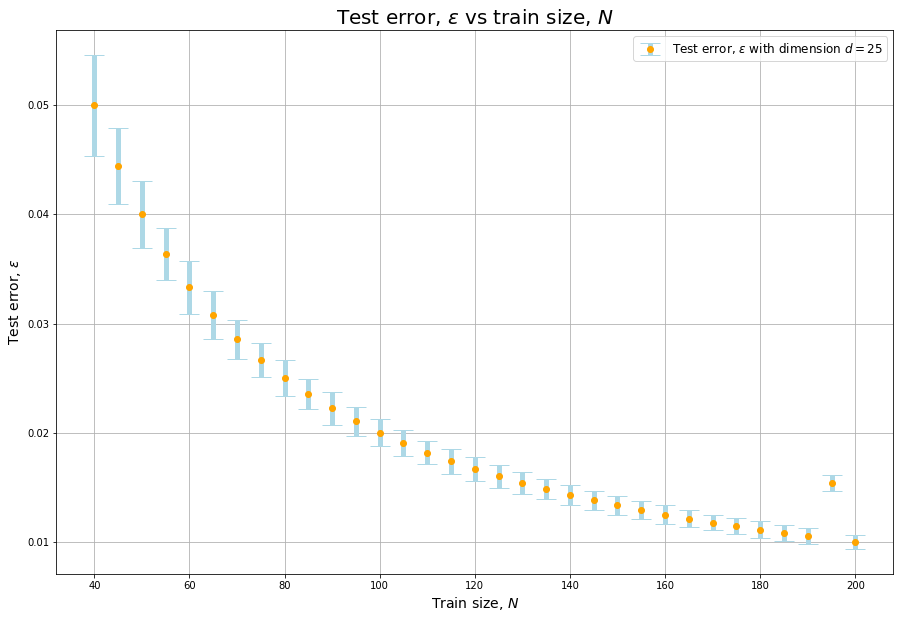

In [16]:
d = 25
np.random.seed(80)
cov, means = generate_distribution(d)

#generate list of train sizes
N = np.arange(40, 205, step = 5)
test_size = 0.5

test_error = []


#--------------------------------------------------------
results = sample_size_vary(N, cov, means, 200)

#approximate epsilon as mean of test errors
err = np.array([pd.Series(i).quantile(0.3) for i in results])

#calclate standard error for approximated epsilons
#to display as error bars
std_err = np.std(results, axis=1)/np.sqrt(results.shape[1])

#--------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 10))

#plot error versus train size plot with error bars
ax.errorbar(N, err, yerr = std_err, fmt = 'o',color = 'orange', 
            ecolor = 'lightblue', elinewidth = 5, capsize=10, label = f"Test error, $\epsilon$ with dimension $d={d}$")

#graph settings
ax.set_xlabel(f"Train size, $N$")
ax.set_ylabel(f"Test error, $\epsilon$")
ax.set_title(f"Test error, $\epsilon$ vs train size, $N$")
ax.legend()
plt.grid()

plt.show()

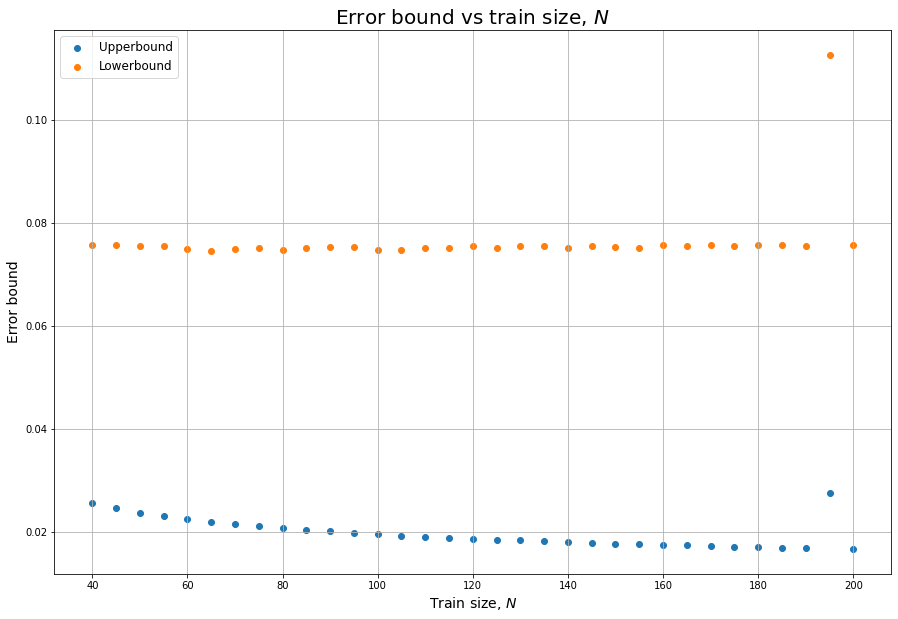

In [17]:
#calculate probability that our model wil perform poorer than epsilon
#with sample size N
delta = np.array([sum(results[i]>err[i])/len(results[i]) for i in range(len(results))])

#calcuate lower and upper bound according to formula
upper = (N*err/((d+1)*np.log(1/err)+np.log(1/delta))).reshape(-1,1)
lower = (N*err/((d+1)+np.log(1/delta))).reshape(-1,1)

fig, ax = plt.subplots(figsize=(15, 10))

#draw upper and lower bound for error vs N
plt.scatter(N, upper, label = "Upperbound")
plt.scatter(N, lower, label = "Lowerbound")

#graph setting
ax.set_xlabel(f"Train size, $N$")
ax.set_ylabel(f"Error bound")
ax.set_title(f"Error bound vs train size, $N$")
ax.legend()

plt.grid()
plt.show()

From the graph, it is similar that upper and lower bounds are constant. I should check this hypothesis by applying linear regression.

In [18]:
C_1_model, C_2_model = LinearRegression().fit(N.reshape(-1,1), lower), LinearRegression().fit(N.reshape(-1,1), upper)
C_1, C_2 = C_1_model.intercept_[0], C_2_model.intercept_[0]

#model.coef_ returns gradient, while model.intercept_ returns intercept
print(f"Grad of lowerbound: {C_1_model.coef_[0][0]} => constant, C_1={C_1}")
print(f"Grad of upperbound: {C_2_model.coef_[0][0]} => constant, C_2={C_2}")

Grad of lowerbound: 4.0306132172281986e-05 => constant, C_1=0.07164997731534463
Grad of upperbound: -3.671825863294315e-05 => constant, C_2=0.02412606938057145


As we can see, gradient of both bounds are almost $0$, thus we can say that they are constant. Theorem 6.8 is confirmed in case of varying train size with fixed number of features.

##Check how $VCdim(\mathcal{H})$ affects bound

Now, I will vary train size to $60 - 600$ and vary dimension of the matrix from $5$ to $60$.

In [61]:
seeds = []
N = np.arange(100, 220, step = 10)
D = np.arange(5, 65, step = 5)
for d in D:
    counter = 0
    while 1:
        np.random.seed(counter)

        cov, means = generate_distribution(d)
        check = sample_size_vary(N, cov, means, 1)

        if min(check)>0.01:
            print(f"Needed seed for dim={d} is {counter}")
            seeds.append(counter)
            break

        counter+=1


Needed seed for dim=5 is 2
Needed seed for dim=10 is 3
Needed seed for dim=15 is 13
Needed seed for dim=20 is 13
Needed seed for dim=25 is 17
Needed seed for dim=30 is 45
Needed seed for dim=35 is 32
Needed seed for dim=40 is 26
Needed seed for dim=45 is 73
Needed seed for dim=50 is 0
Needed seed for dim=55 is 320
Needed seed for dim=60 is 15


LDA shows great performance on the gaussian-distributed data and error converges very fast with increasing number of samples. Thus, I am looking for covariance matrices, where test eror hasn't converged to 0. Here are the seeds for these matrices used only for reproducibility.

In [64]:
seeds = [2, 3, 13, 13, 17, 45, 32, 26, 73, 0, 320, 15]

In [65]:
D = np.arange(5, 65, step = 5)
test_size = 0.5

test_error = []
summary = {
    'err': [],
    'std': [],
    'delta': [],
    'epsilon':[],
}



for d, s in zip(D, seeds):

    N = np.arange(d*2, d*2+100, step = 5)


    np.random.seed(s)

    cov, means = generate_distribution(d)

    results = sample_size_vary(N, cov, means, 200)

    #approximate epsilon as 70% percentile (smaller better) of test errors
    err = np.mean(results, axis=1)
    epsilon = np.quantile(results, 0.3, axis=1)
            
            
    #calclate standard error for approximated epsilons
    #to display as error bars
    std_err = np.std(results, axis=1)/np.sqrt(results.shape[1])
    delta = np.array([sum(results[i]>epsilon[i])/len(results[i]) for i in range(len(results))])

    print(f"Generate data for dim={d}")

    summary['err'].append(err)
    summary['std'].append(std_err)
    summary['delta'].append(delta)
    summary['epsilon'].append(epsilon)



Generate data for dim=5
Generate data for dim=10
Generate data for dim=15
Generate data for dim=20
Generate data for dim=25
Generate data for dim=30
Generate data for dim=35
Generate data for dim=40
Generate data for dim=45
Generate data for dim=50
Generate data for dim=55
Generate data for dim=60


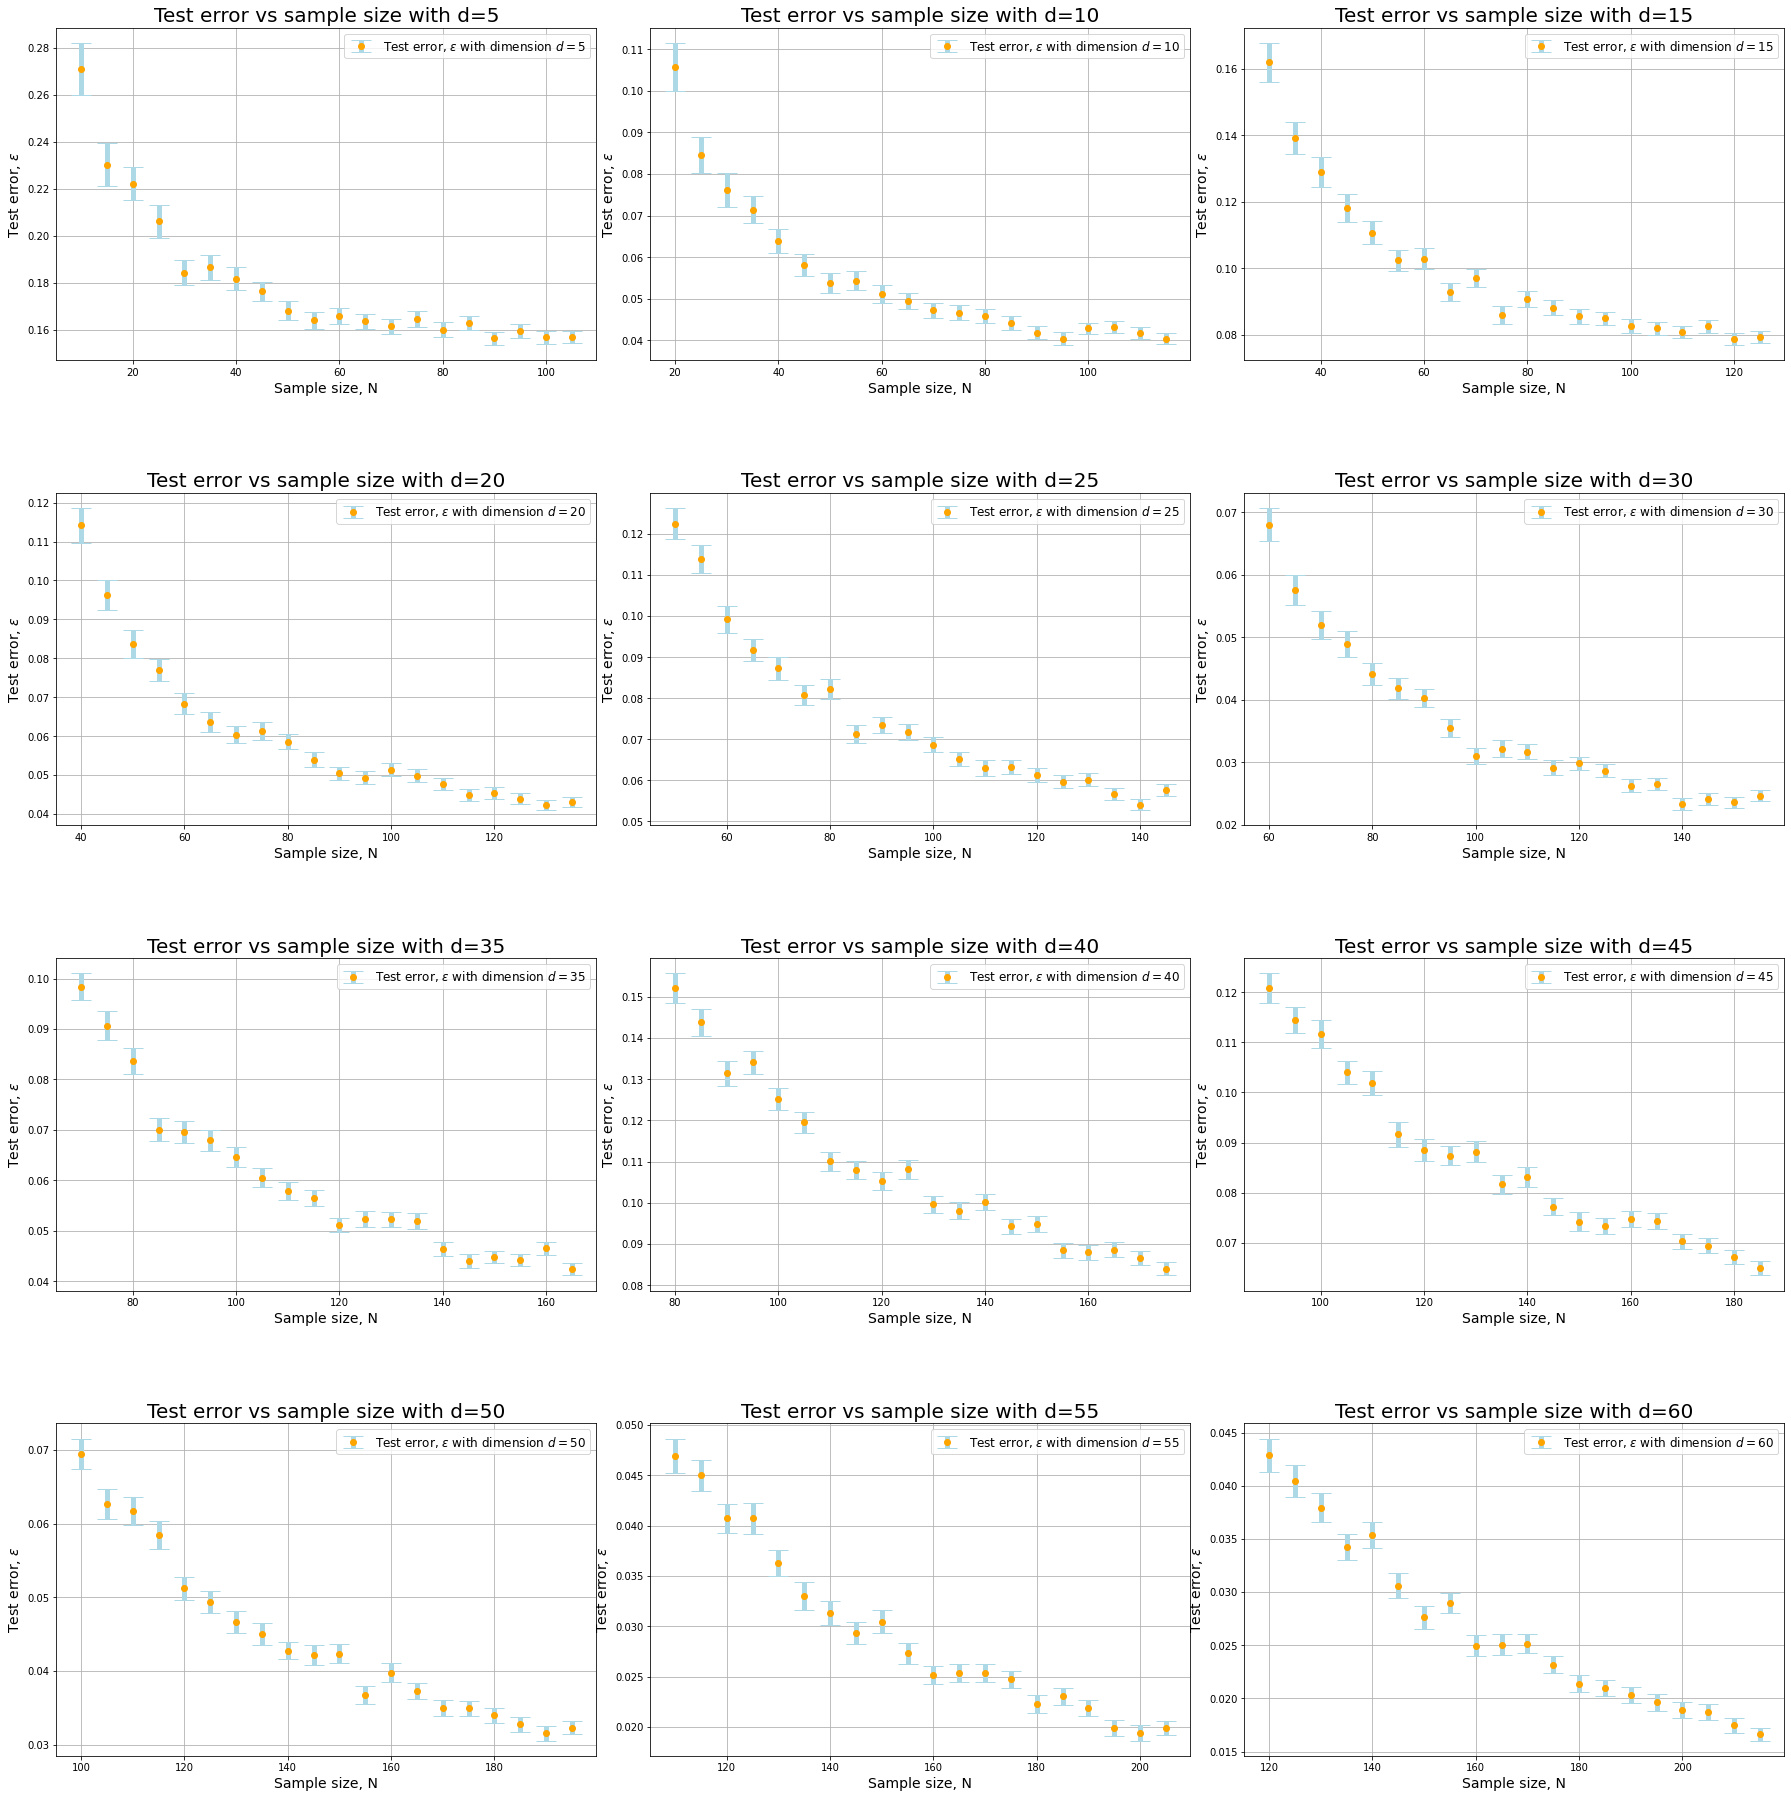

In [67]:
fig, axs = plt.subplots(4, 3, figsize=(30, 30))


counter = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        N = np.arange(D[counter]*2,D[counter]*2+100, step = 5)

        
        axs[i,j].errorbar(N, summary['err'][counter], yerr = summary['std'][counter], fmt = 'o',color = 'orange', 
            ecolor = 'lightblue', elinewidth = 5, capsize=10, label = f"Test error, $\epsilon$ with dimension $d={D[counter]}$")

        axs[i,j].set_xlabel(f"Sample size, N")
        axs[i,j].set_ylabel(f"Test error, $\epsilon$")

        axs[i,j].set_title(f"Test error vs sample size with d={D[counter]}")
        axs[i,j].legend()
        axs[i,j].grid()
        counter+=1

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)

plt.show()

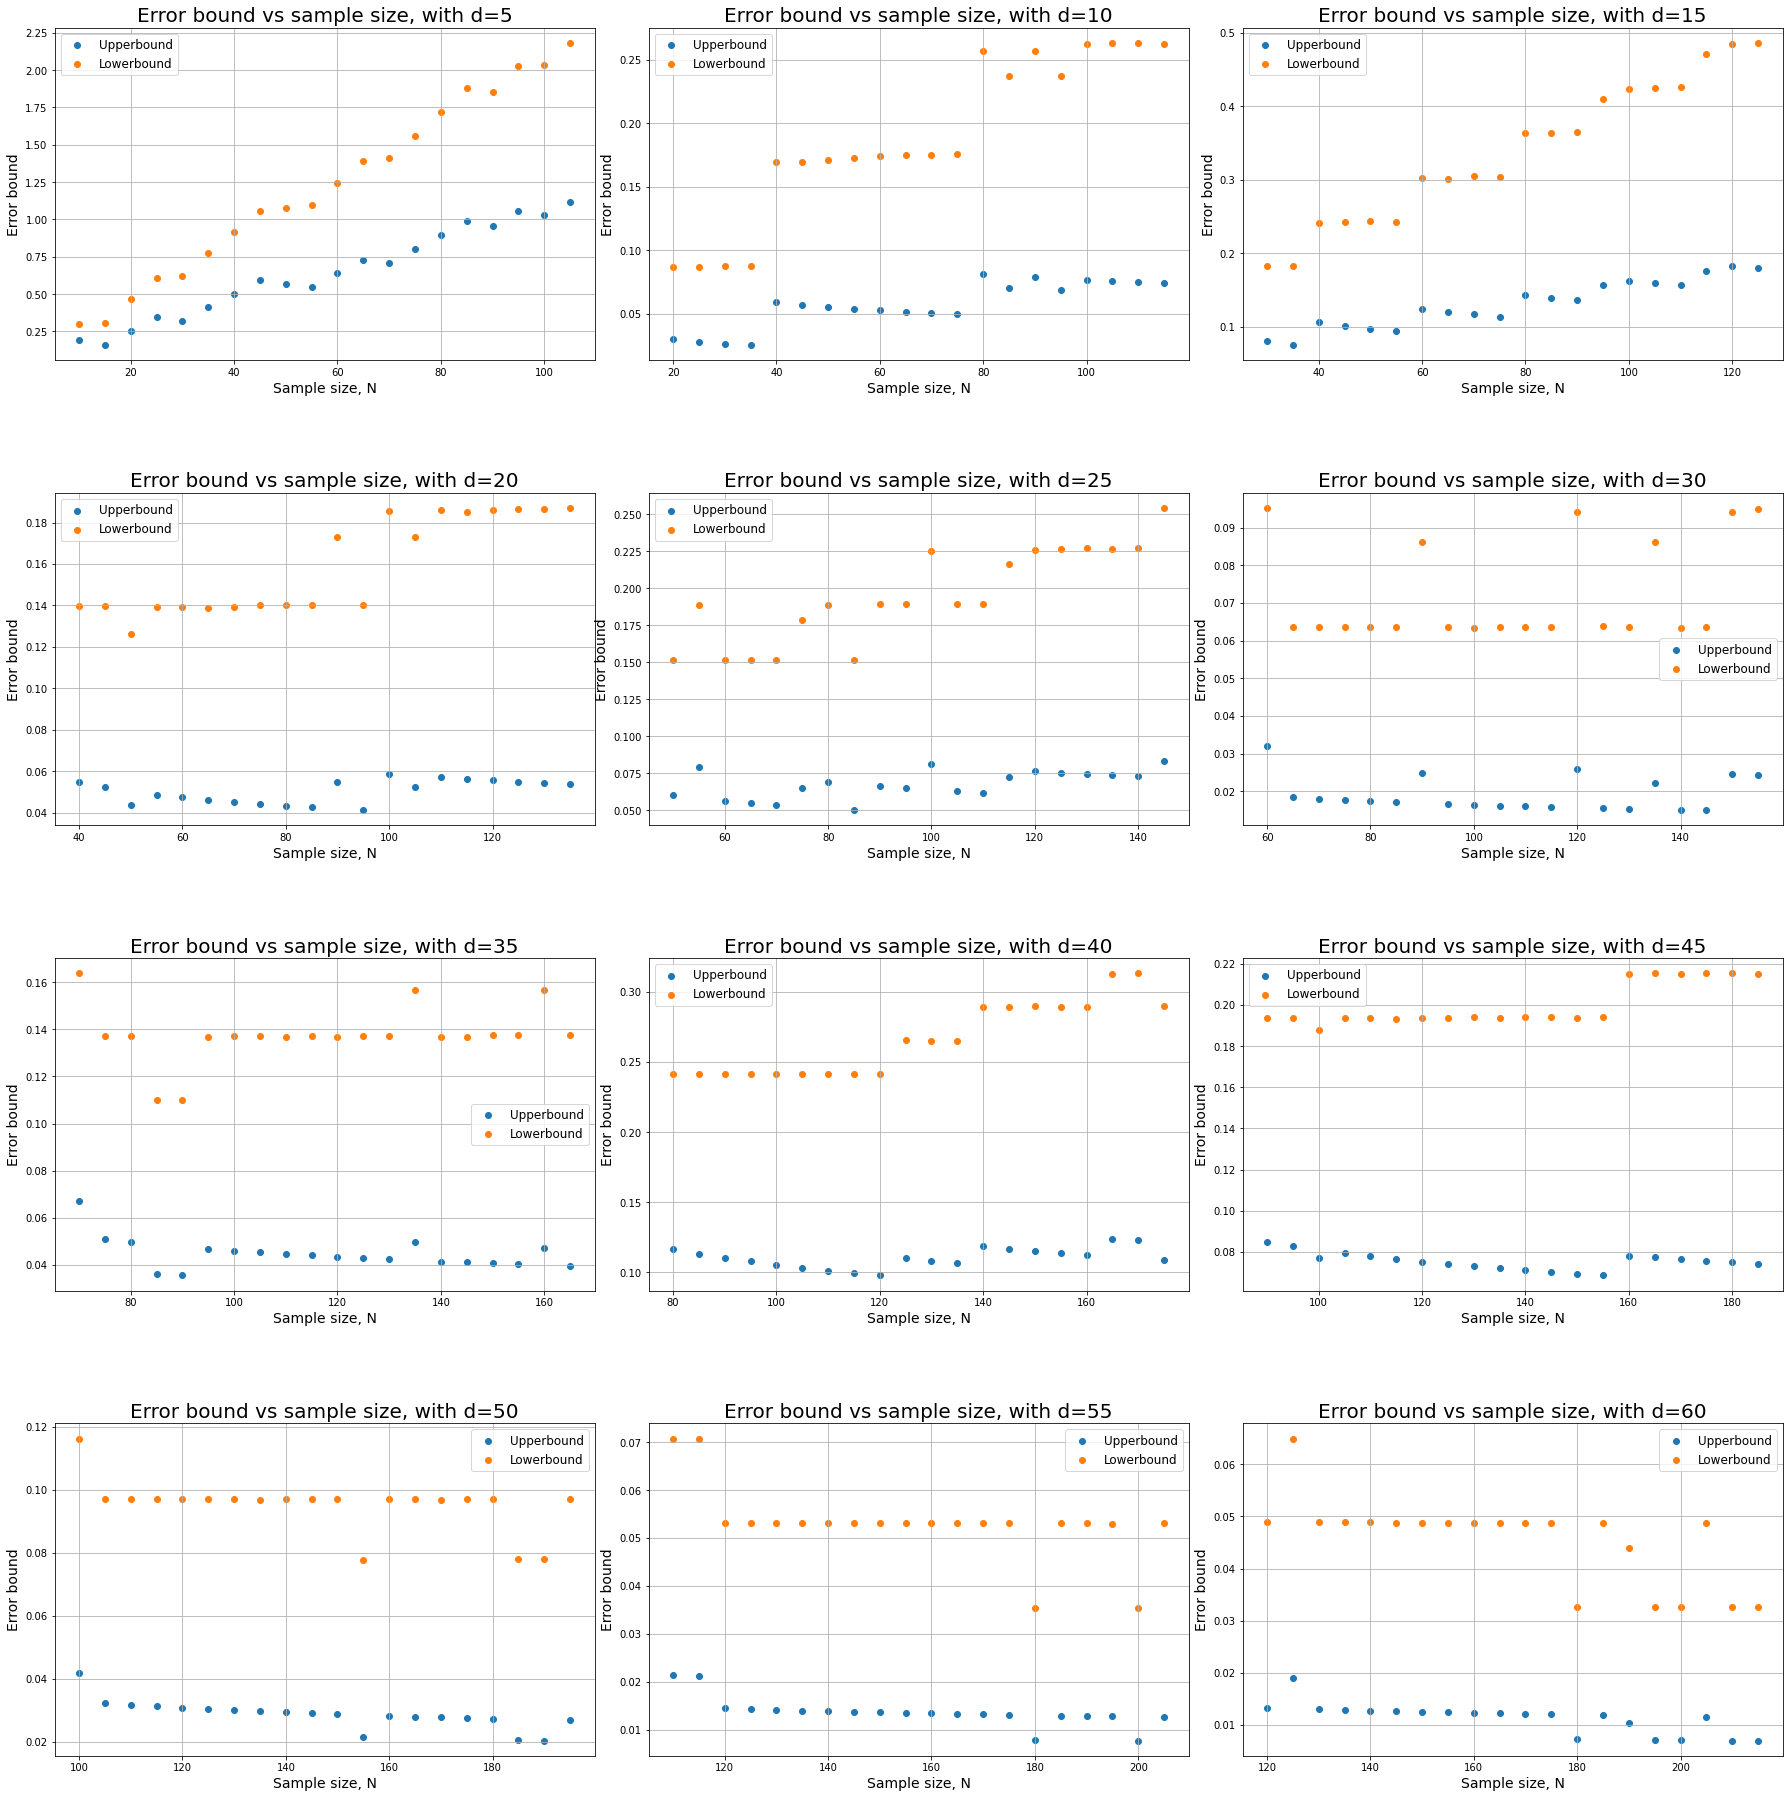

In [70]:
fig, axs = plt.subplots(4, 3, figsize=(30, 30))

grad = []
intercept = []

data_dict = {
    'Dimension' : [],
    'Gradient of lower bound' : [],
    'Intercept of lower bound' : [],    
    'Gradient of upper bound' : [],
    'Intercept of upper bound' : [], 
}
counter = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        N = np.arange(D[counter]*2,D[counter]*2+100, step = 5)

        err = summary['epsilon'][counter]
        delta = summary['delta'][counter]

        upper = (N*err/((D[counter]+1)*np.log(1/err)+np.log(1/delta))).reshape(-1,1)
        lower = (N*err/((D[counter]+1)+np.log(1/delta))).reshape(-1,1)
        
        C_1_model, C_2_model = LinearRegression().fit(N.reshape(-1,1), lower), LinearRegression().fit(N.reshape(-1,1), upper)
        C_1, C_2 = C_1_model.intercept_[0], C_2_model.intercept_[0]

        data_dict['Dimension'].append(D[counter])
        data_dict['Gradient of lower bound'].append(C_1_model.coef_[0][0])
        data_dict['Intercept of lower bound'].append(C_1)
        data_dict['Gradient of upper bound'].append(C_2_model.coef_[0][0])
        data_dict['Intercept of upper bound'].append(C_2)

        #draw upper and lower bound for error vs N
        axs[i,j].scatter(N, upper, label = "Upperbound")
        axs[i,j].scatter(N, lower, label = "Lowerbound")


        axs[i,j].set_xlabel(f"Sample size, N")
        axs[i,j].set_ylabel(f"Error bound")

        axs[i,j].set_title(f"Error bound vs sample size, with d={D[counter]}")
        axs[i,j].legend()
        axs[i,j].grid()

        counter+=1

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)

plt.show()

In [71]:
data_dict = pd.DataFrame(data_dict)

,Dimension,Gradient of lower bound,Intercept of lower bound,Gradient of upper bound,Intercept of upper bound
0,5,0.020201,0.064867,0.010106,0.059747
1,10,0.002058,0.049821,0.000539,0.020694
2,15,0.003251,0.086403,0.001078,0.047848
3,20,0.000697,0.097717,0.000091,0.042373
4,25,0.000959,0.101544,0.000192,0.049106
5,30,0.000113,0.059932,-0.000016,0.020967
6,35,0.000095,0.126468,-0.000099,0.056460
7,40,0.000819,0.162233,0.000106,0.097146
8,45,0.000286,0.160563,-0.000069,0.084917
9,50,-0.000157,0.118180,-0.000122,0.046532


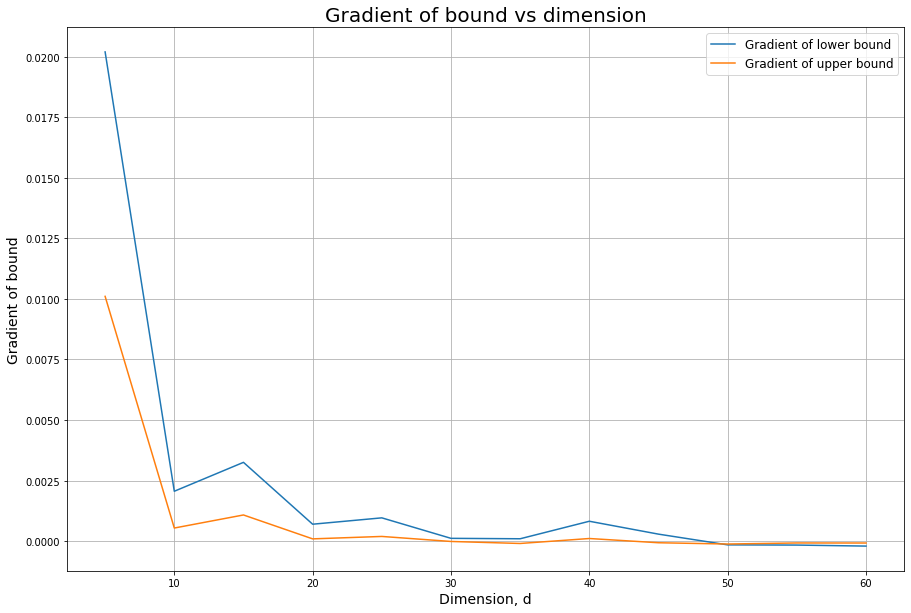

In [78]:
fig, axs = plt.subplots(figsize=(15, 10))

axs.set_xlabel(f"Dimension, d")
axs.set_ylabel(f"Gradient of bound")
axs.set_title(f"Gradient of bound vs dimension")
axs.plot(data_dict['Dimension'], data_dict['Gradient of lower bound'], label = "Gradient of lower bound")
axs.plot(data_dict['Dimension'], data_dict['Gradient of upper bound'], label = "Gradient of upper bound")
axs.legend()
plt.grid()
plt.show()

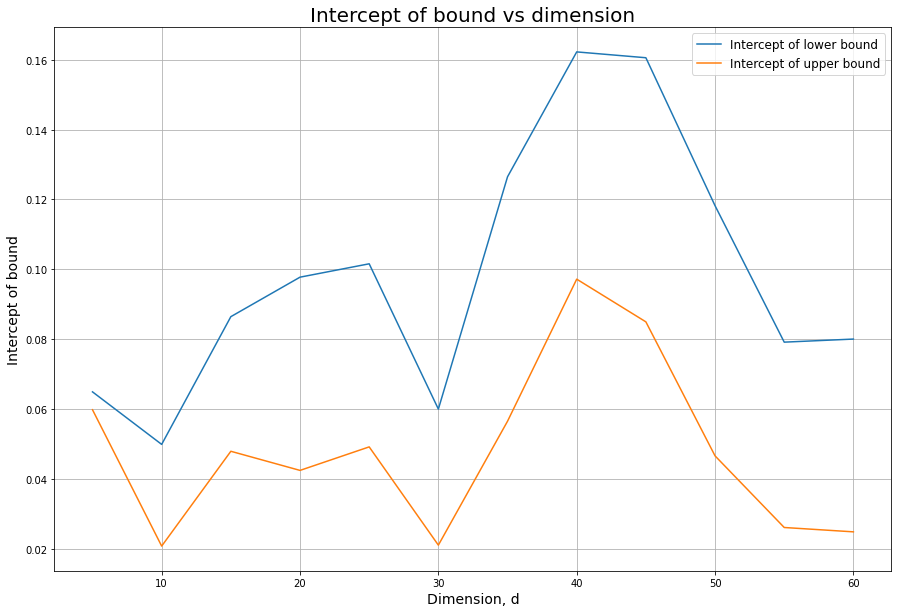

In [80]:
fig, axs = plt.subplots(figsize=(15, 10))

axs.set_xlabel(f"Dimension, d")
axs.set_ylabel(f"Intercept of bound")
axs.set_title(f"Intercept of bound vs dimension")
plt.plot(data_dict['Dimension'], data_dict['Intercept of lower bound'], label = "Intercept of lower bound")
plt.plot(data_dict['Dimension'], data_dict['Intercept of upper bound'], label = "Intercept of upper bound")
axs.legend()
plt.grid()
plt.show()

#Test on Real data

##Data preprocessing

In [34]:
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.loc[df['EKG results']== 2, 'EKG results'] = 1
df = pd.get_dummies(df, columns=['Chest pain type', 'Slope of ST', 'Heart Disease'], drop_first = True)

labels = df['Heart Disease_Presence']

In [35]:
df

,Age,Sex,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Number of vessels fluro,Thallium,Chest pain type_2,Chest pain type_3,Chest pain type_4,Slope of ST_2,Slope of ST_3,Heart Disease_Presence
0,70,1,130,322,0,1,109,0,2.4,3,3,0,0,1,1,0,1
1,67,0,115,564,0,1,160,0,1.6,0,7,0,1,0,1,0,0
2,57,1,124,261,0,0,141,0,0.3,0,7,1,0,0,0,0,1
3,64,1,128,263,0,0,105,1,0.2,1,7,0,0,1,1,0,0
4,74,0,120,269,0,1,121,1,0.2,1,3,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,172,199,1,0,162,0,0.5,0,7,0,1,0,0,0,0
266,44,1,120,263,0,0,173,0,0.0,0,7,1,0,0,0,0,0
267,56,0,140,294,0,1,153,0,1.3,0,3,1,0,0,1,0,0
268,57,1,140,192,0,0,148,0,0.4,0,6,0,0,1,1,0,0


In [36]:
Counter(list((labels.values).ravel()))

Counter({1: 120, 0: 150})

Almost balanced classes!

In [37]:
numerical = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro','Thallium']

for col in numerical:
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1,1))

Now, data is normalized

In [38]:
df[numerical].describe()

,Age,BP,Cholesterol,Max HR,ST depression,Number of vessels fluro,Thallium
count,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02
mean,3.667848e-16,5.682697e-16,-2.467162e-16,2.631640e-17,-5.263280e-17,-6.579099e-17,8.552829e-17
std,1.001857e+00,1.001857e+00,1.001857e+00,1.001857e+00,1.001857e+00,1.001857e+00,1.001857e+00
min,-2.797275e+00,-2.094649e+00,-2.396942e+00,-3.402609e+00,-9.185652e-01,-7.115349e-01,-8.757058e-01
25%,-7.075676e-01,-6.363095e-01,-7.105825e-01,-7.212705e-01,-9.185652e-01,-7.115349e-01,-8.757058e-01
50%,6.232461e-02,-7.540984e-02,-9.031247e-02,1.653012e-01,-2.187060e-01,-7.115349e-01,-8.757058e-01
75%,7.222322e-01,4.854898e-01,5.881079e-01,7.058937e-01,4.811532e-01,3.498708e-01,1.189277e+00
max,2.481986e+00,3.850888e+00,6.093004e+00,2.262800e+00,4.505343e+00,2.472682e+00,1.189277e+00


By theorem 6.8, it is assumed that both classes should have the same covariance matrix.

In [39]:
data_class_0 = np.array(df.loc[df['Heart Disease_Presence'] == 0].drop("Heart Disease_Presence", axis=1)).T
data_class_1 = np.array(df.loc[df['Heart Disease_Presence'] == 1].drop("Heart Disease_Presence", axis=1)).T
cov_0 = np.cov(data_class_0)
cov_1 = np.cov(data_class_1)

Are this matrices are similar? We can check by finding frobenius norm.

In [40]:
similarity = 1-np.linalg.norm(cov_0-cov_1, ord='fro')/(np.linalg.norm(cov_0, ord='fro')+np.linalg.norm(cov_1, ord='fro'))
print(f"Two covariance matrices are similar by {similarity*100}%")

Two covariance matrices are similar by 70.70979728698161%


In [41]:
data_class_0_num = np.array(df.loc[df['Heart Disease_Presence'] == 0][numerical]).T
data_class_1_num = np.array(df.loc[df['Heart Disease_Presence'] == 1][numerical]).T

In [42]:
data_class_0_num.shape

(7, 150)

The covariance matrices are not the same. Now check if the data are distributed with gaussian and linearly separable. I will judge it by looking at graphical representation.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


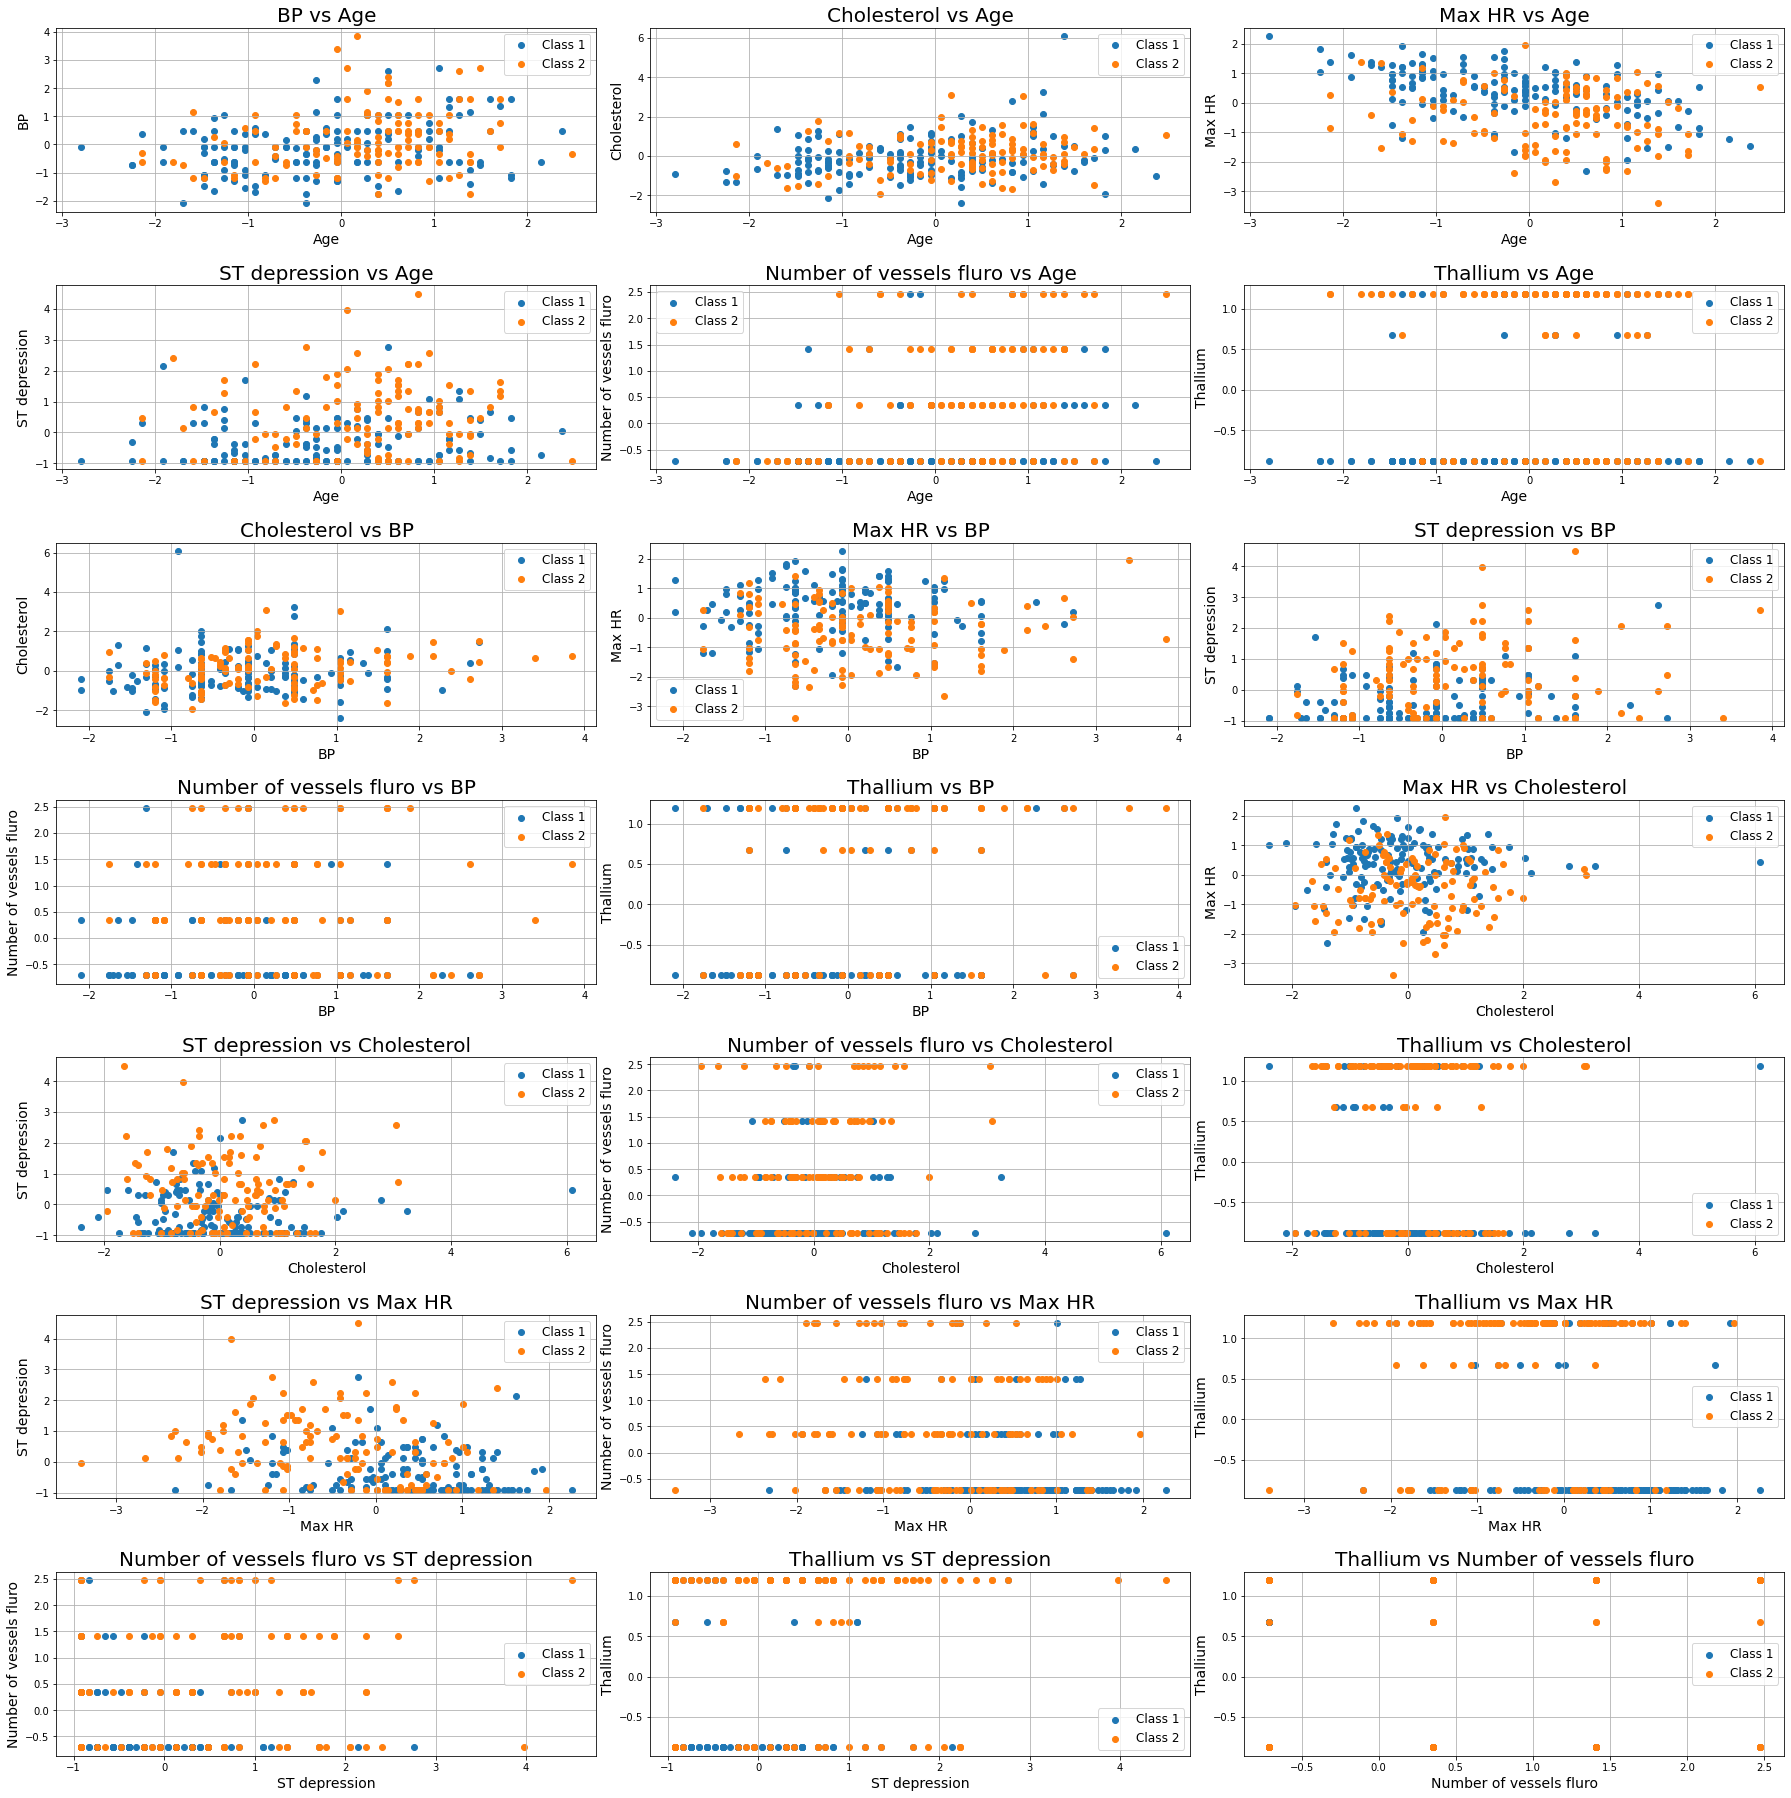

In [43]:
data = []
class_names = []

d = 7 

for i in range(d-1):
    for j in range(i+1,d):

        data.append([[data_class_0_num[i], data_class_0_num[j]], [data_class_1_num[i], data_class_1_num[j]]])
        class_names.append((numerical[i],numerical[j]))

data = np.array(data)

fig, axs = plt.subplots(7, 3, figsize=(30, 30))
counter = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        x1, y1 = data[counter][0]
        axs[i,j].scatter(x1, y1, label = "Class 1")

        x2, y2 = data[counter][1]
        axs[i,j].scatter(x2, y2, label = "Class 2")

        axs[i,j].set_xlabel(f"{class_names[counter][0]}")
        axs[i,j].set_ylabel(f"{class_names[counter][1]}")

        axs[i,j].set_title(f"{class_names[counter][1]} vs {class_names[counter][0]}")
        axs[i,j].legend()
        axs[i,j].grid()
        counter+=1

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)

plt.show()

Only some of the feature are distributed as gaussian.

##Try to classify LDA on real data

In [44]:
data = np.array(df.drop('Heart Disease_Presence', axis=1))
labels = np.array(labels)

N, d = data.shape
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, shuffle = True)

model = LDA().fit(X_train, y_train.ravel())
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
print(f"Accuracy of the model: {acc}%")

Accuracy of the model: 0.8703703703703703%


##Vary train size

Now, repeat the same experiment with varying test size (from 10% to 95%)

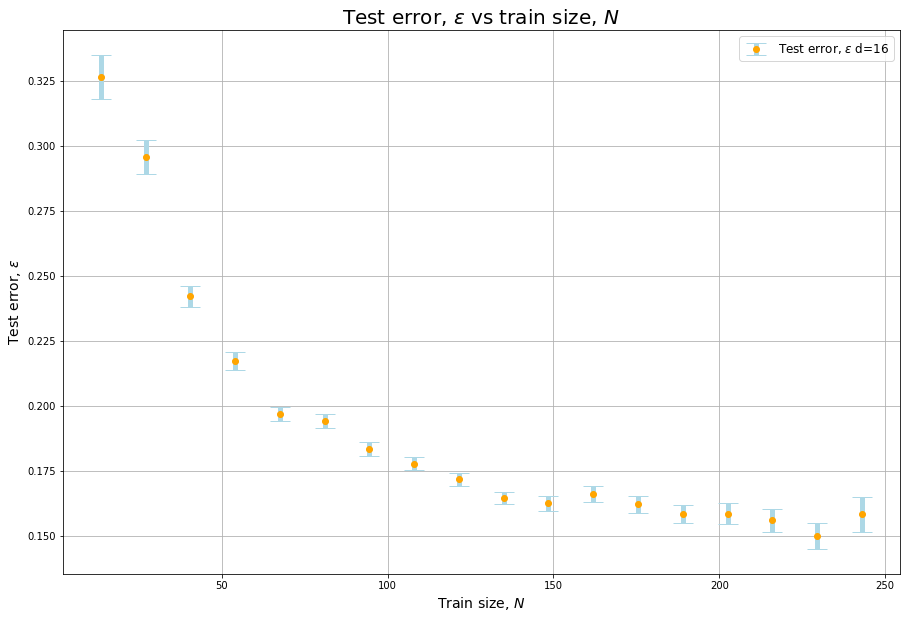

In [48]:
test_size = np.arange(0.1, 1, step=0.05)

results = []
for t in test_size:
    err = []
    for j in range(100):

        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=t, shuffle = True)
        model = LDA().fit(X_train, y_train.ravel())
        pred = model.predict(X_test)
        err.append(1-accuracy_score(pred, y_test))

    results.append(err)

#--------------------------------------------------------
results = np.array(results)

#approximate epsilon as mean of test errors
err = np.mean(results, axis=1)

#calclate standard error for approximated epsilons
#to display as error bars
std_err = np.std(results, axis=1)/np.sqrt(results.shape[1])

#--------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 10))

#plot error versus train size plot with error bars
ax.errorbar(N*(1-test_size), err, yerr = std_err, fmt = 'o',color = 'orange', 
            ecolor = 'lightblue', elinewidth = 5, capsize=10, label = f"Test error, $\epsilon$ d={16}")

#graph settings
ax.set_xlabel(f"Train size, $N$")
ax.set_ylabel(f"Test error, $\epsilon$")
ax.set_title(f"Test error, $\epsilon$ vs train size, $N$")
ax.legend()
plt.grid()

plt.show()

In [46]:
eps = np.percentile(results, 0.3, axis = 1)
delta = np.array([sum(results[i]>eps[i])/len(results[i]) for i in range(len(results))])
upper = (N*(1-test_size)*eps/((d+1)*np.log(1/eps)+np.log(1/delta))).reshape(-1,1)
lower = (N*(1-test_size)*eps/((d+1)+np.log(1/delta))).reshape(-1,1)

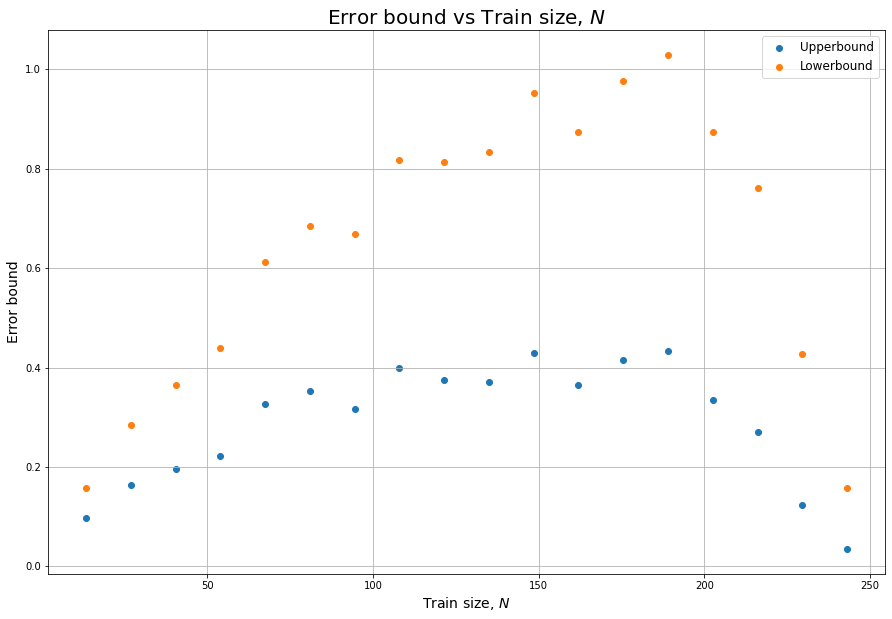

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))

#draw upper and lower bound for error vs N
plt.scatter(N*(1-test_size), upper, label = "Upperbound")
plt.scatter(N*(1-test_size), lower, label = "Lowerbound")

#graph setting
ax.set_xlabel(f"Train size, $N$")
ax.set_ylabel(f"Error bound")
ax.set_title(f"Error bound vs Train size, $N$")
ax.legend()

plt.grid()
plt.show()

##Vary number of features

In [49]:
def gen_bin_list(i):
    row = [bool(int(x)) for x in bin(i)[2:]]
    
    if sum(row)<16:
        row = [bool(0)]*(16-len(row))+row

    return row

def subset_features(data, mask):
    return data.T[mask].T

dimension = dict()

for j in [gen_bin_list(i) for i in range(1, 65536)]:
    temp = sum(j)
    if temp in dimension.keys():
        dimension[temp].append(j)
    else:
        dimension[temp] = [j]

In [ ]:
test_size = np.arange(0.15, 0.8, step=0.05)[::-1]
summary = []
for t in test_size:

    print(f"------------------\nTrain size: {data.shape[0]*(1-t)}")

    result = []
    for set_feat_d in dimension.keys():
        print(f"Do simulation with d={set_feat_d}")
        err = []

        if len(dimension[set_feat_d])==1:
            idx = [0]*500
        else:
            idx = list(np.random.randint(0, len(dimension[set_feat_d])-1, 500))
        sub = np.array(dimension[set_feat_d])[idx]

        print(sub.shape)

        for i, mask in enumerate(sub):

            
                X_train, X_test, y_train, y_test = train_test_split(subset_features(data, mask), labels, test_size=t, shuffle = True)
                model = LDA().fit(X_train, y_train.ravel())
                pred = model.predict(X_test)
                err.append(1-accuracy_score(pred, y_test))
            

        result.append(np.array(err))

    result = np.array(result)
    summary.append(result)

summary = np.array(summary)


In [51]:
summary.shape

(13, 16, 500)

In [55]:
err = np.mean(summary, axis=2).T
eps =  np.percentile(summary, 0.3, axis=2).T
std = np.std(summary, axis=2).T/np.sqrt(summary.shape[2]).T

delta = []
for j in range(16):

    dt = summary[:,j,:]
    d = np.array([sum(dt[i]>eps[j][i]-0.1)/dt.shape[1] for i in range(dt.shape[0])])
    delta.append(d)
    
delta = np.array(delta)


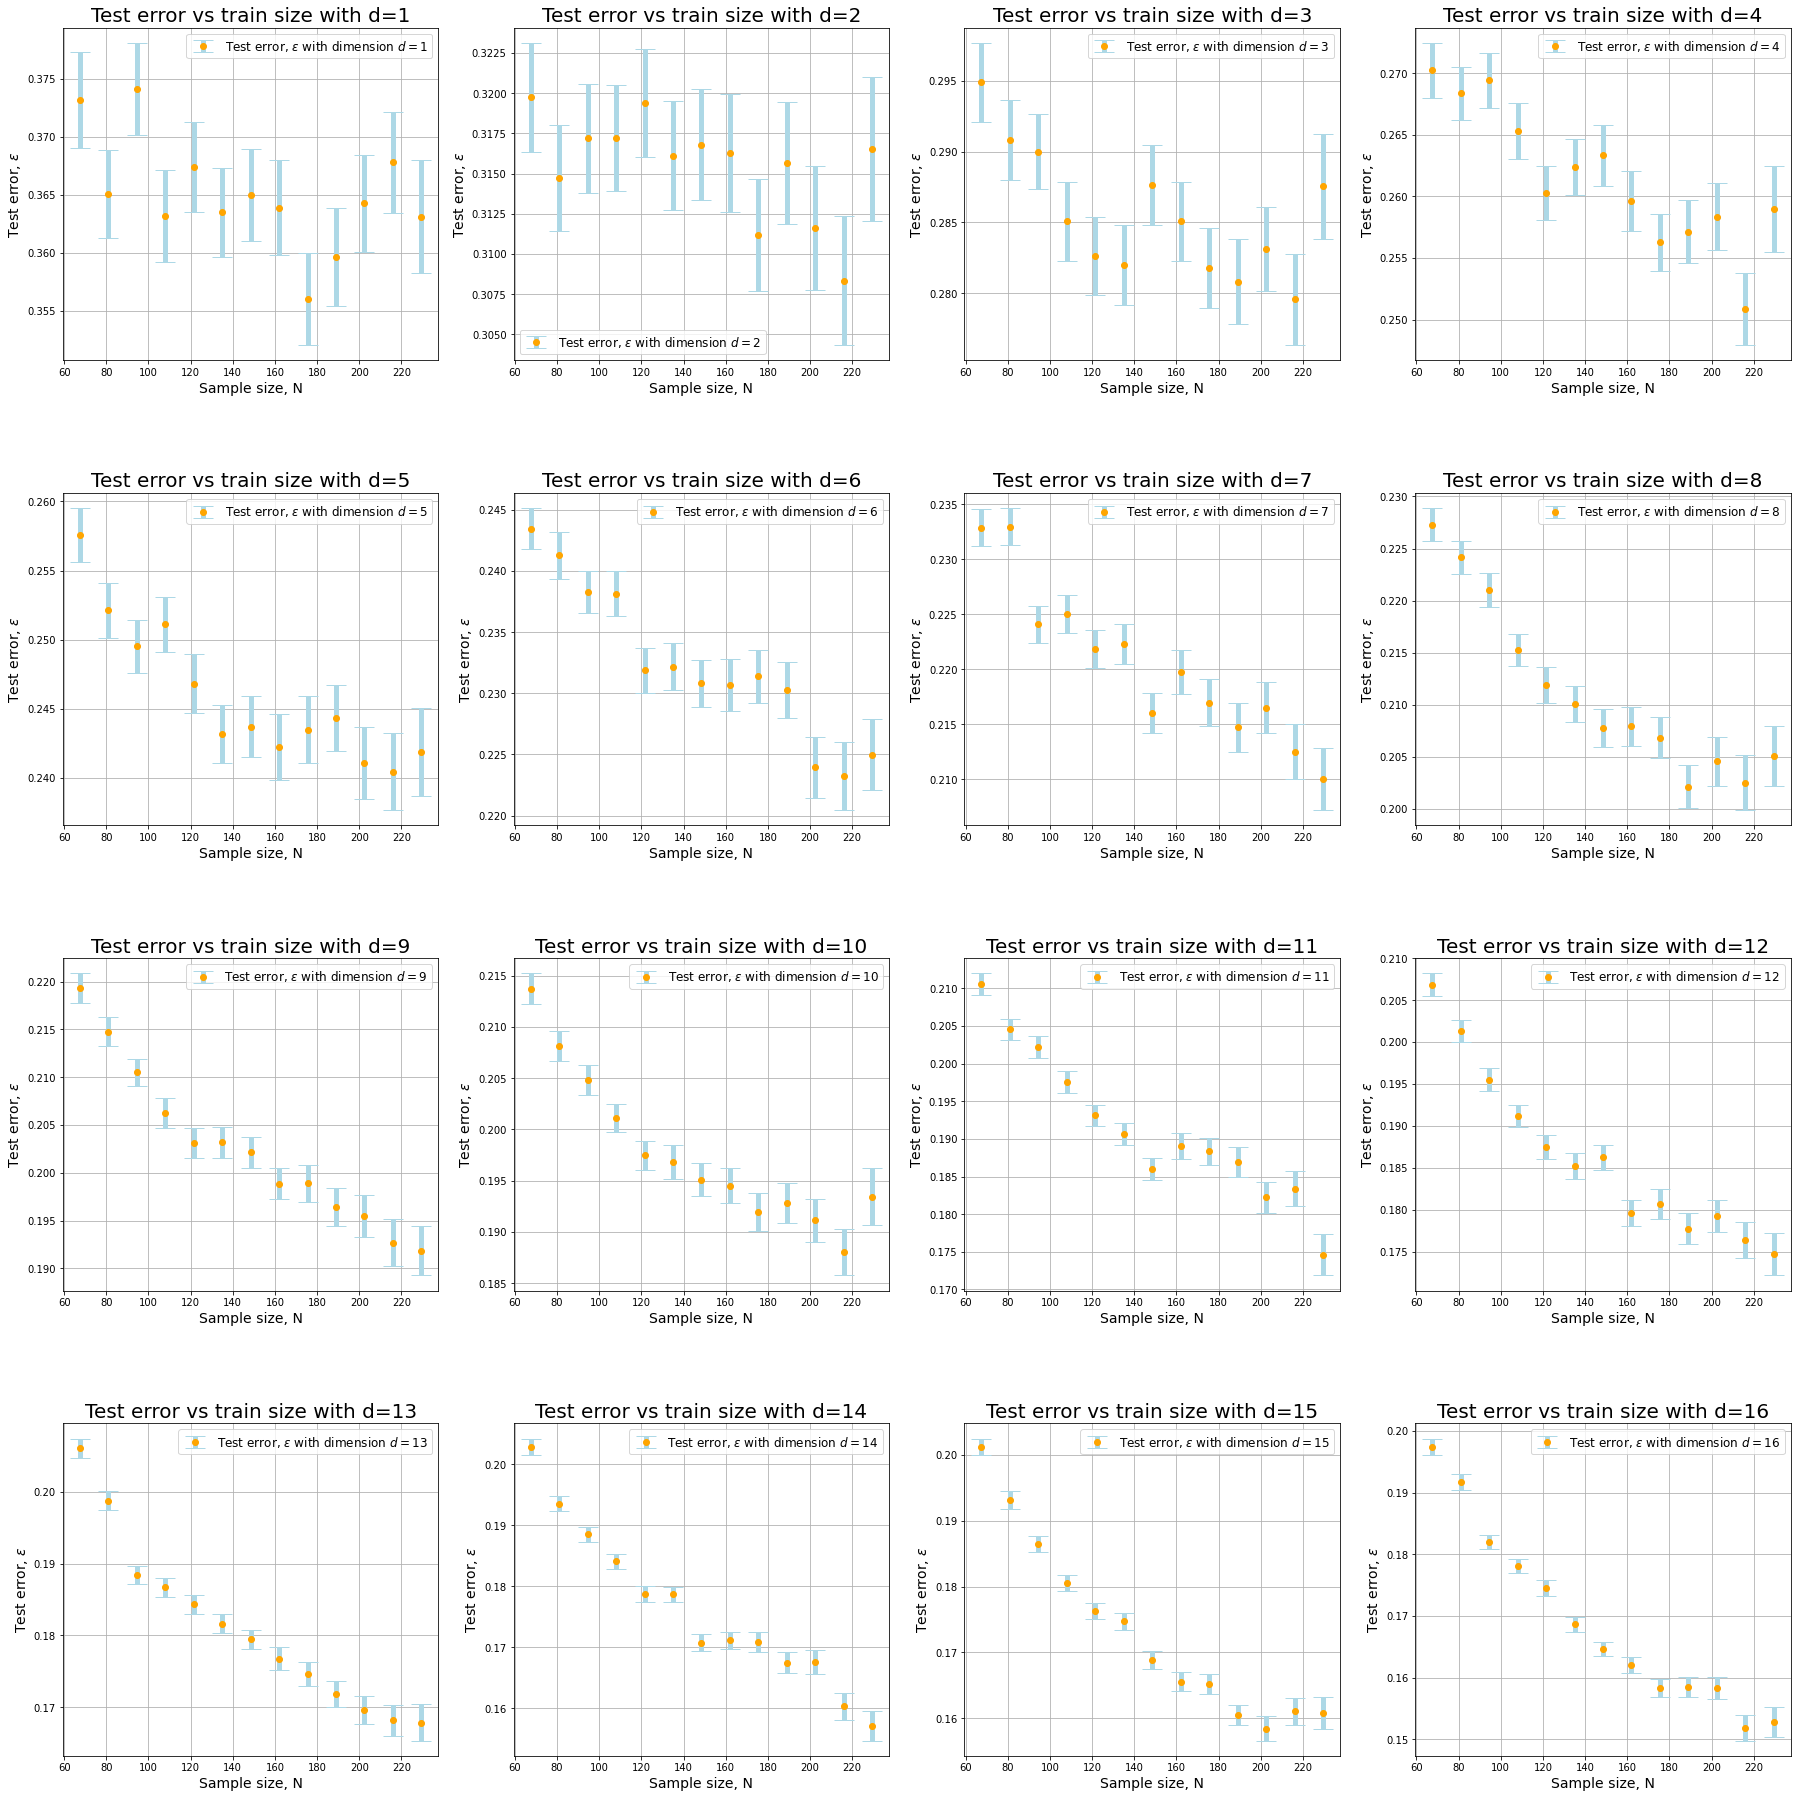

In [56]:
train_size = data.shape[0]*(1-test_size)
D = np.arange(1,17)


fig, axs = plt.subplots(4, 4, figsize=(30, 30))

counter = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        
        axs[i,j].errorbar(train_size, err[counter], yerr = std[counter], fmt = 'o',color = 'orange', 
            ecolor = 'lightblue', elinewidth = 5, capsize=10, label = f"Test error, $\epsilon$ with dimension $d={D[counter]}$")

        axs[i,j].set_xlabel(f"Sample size, N")
        axs[i,j].set_ylabel(f"Test error, $\epsilon$")

        axs[i,j].set_title(f"Test error vs train size with d={D[counter]}")
        axs[i,j].legend()
        axs[i,j].grid()
        counter+=1

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

plt.show()

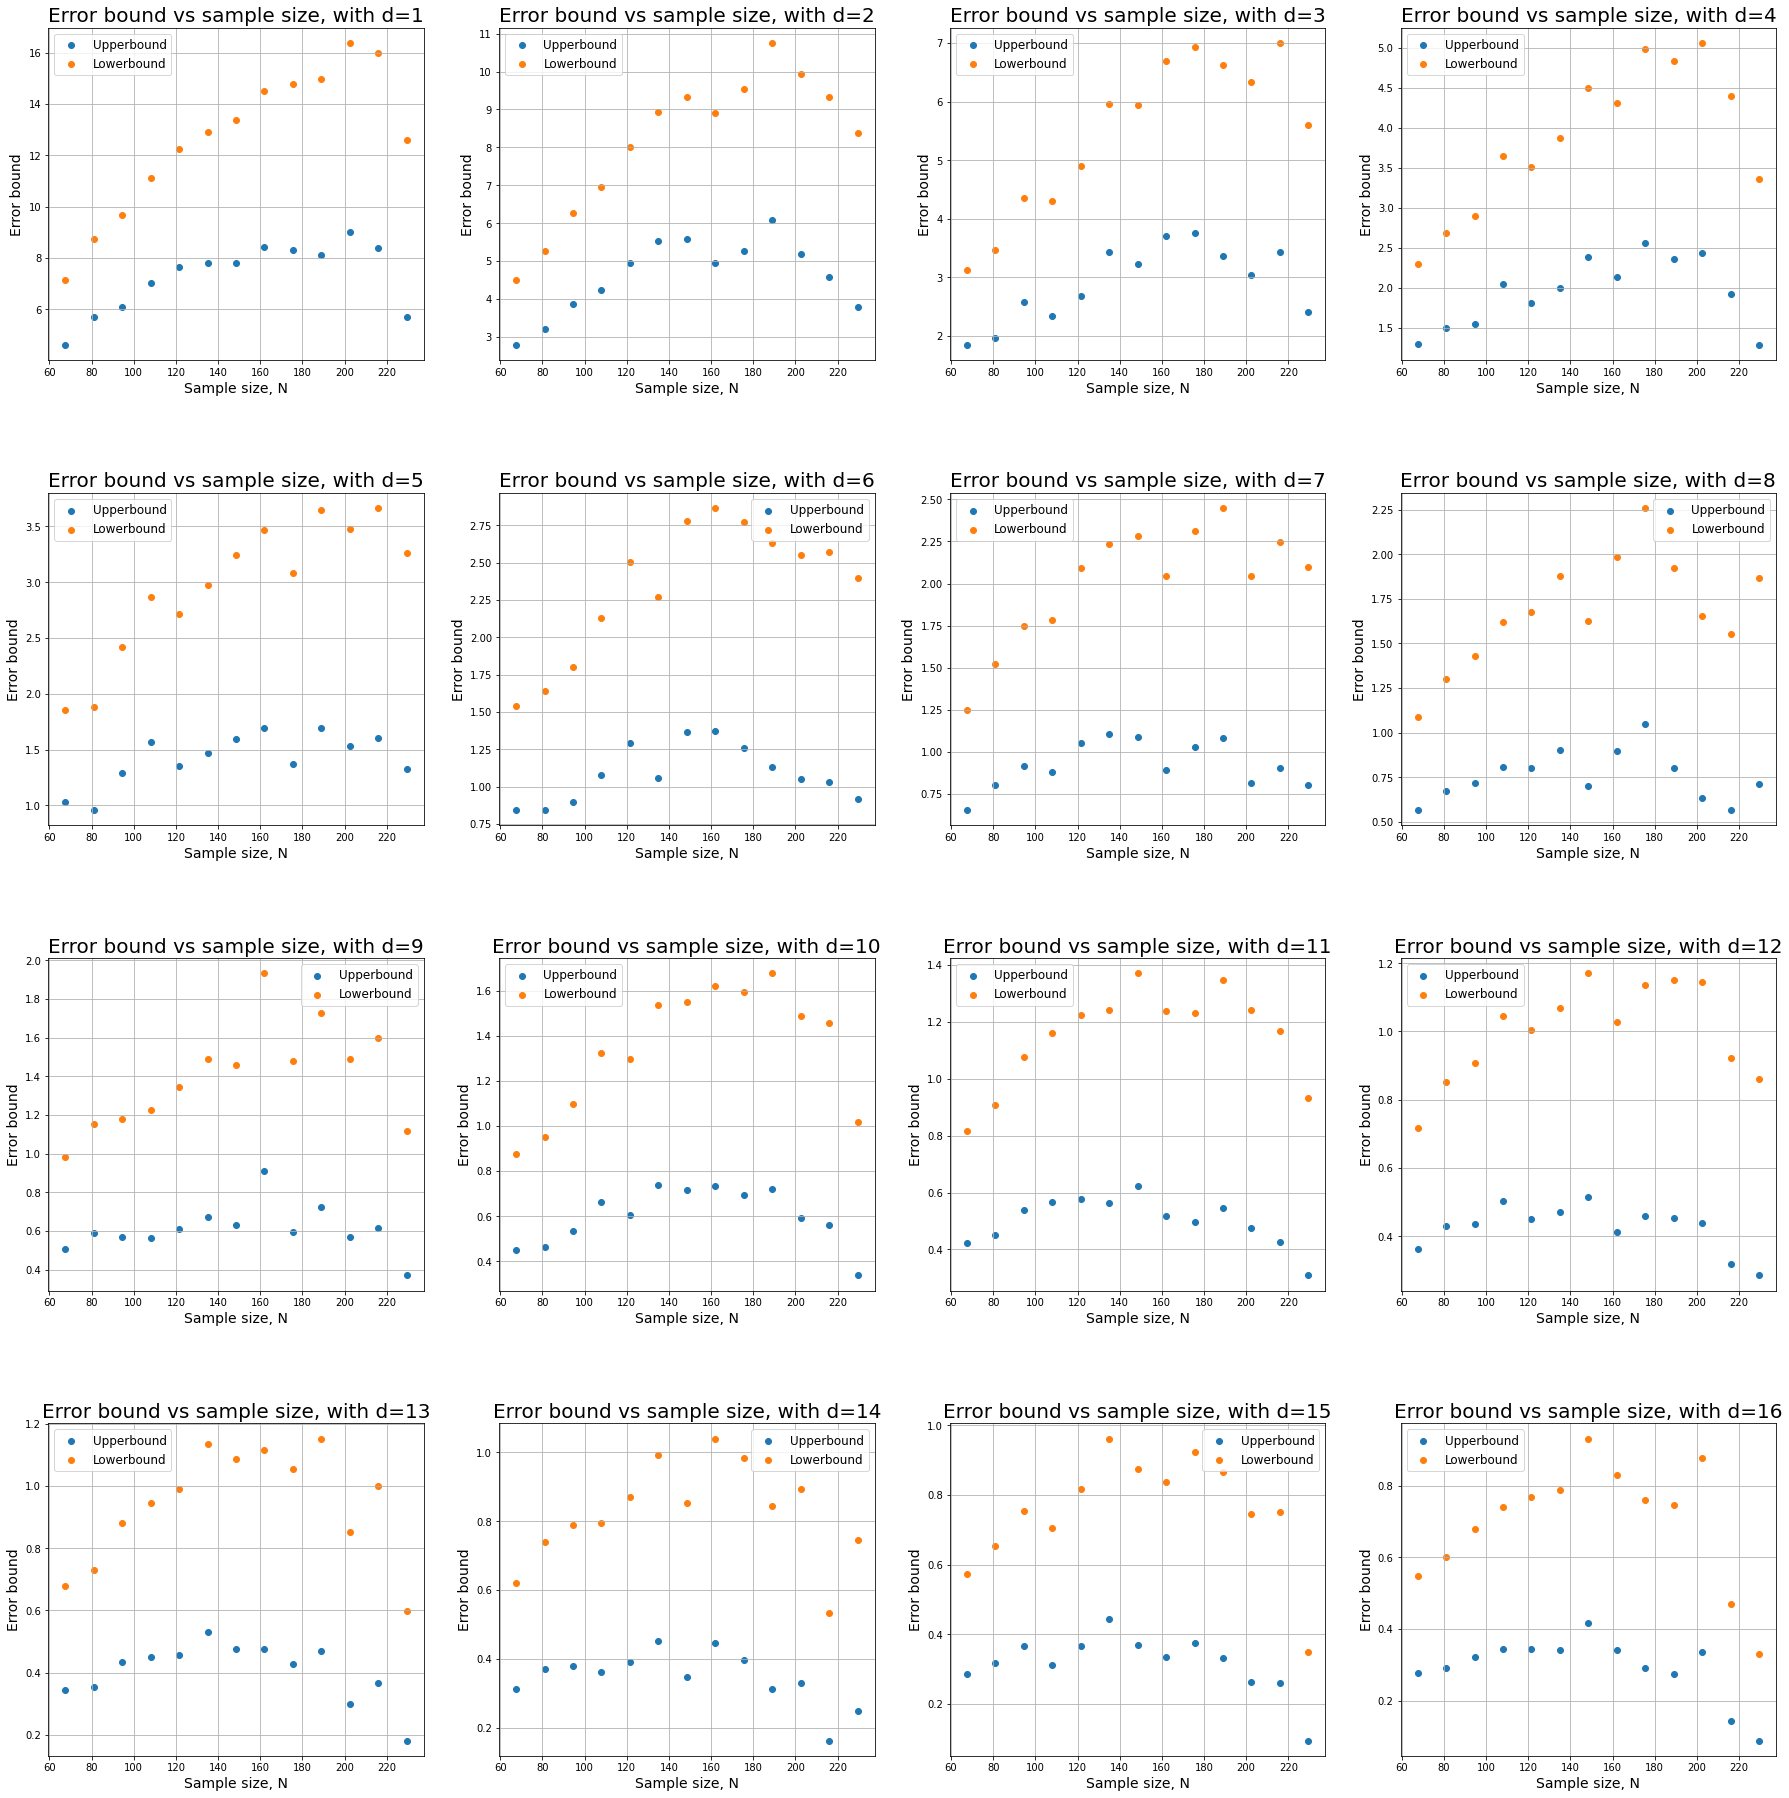

In [54]:
fig, axs = plt.subplots(4, 4, figsize=(30, 30))


counter = 0

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        upper = (train_size*eps[counter]/((D[counter]+1)*np.log(1/eps[counter])+np.log(1/delta[counter]))).reshape(-1,1)
        lower = (train_size*eps[counter]/((D[counter]+1)+np.log(1/delta[counter]))).reshape(-1,1)

        #draw upper and lower bound for error vs N
        axs[i,j].scatter(train_size, upper, label = "Upperbound")
        axs[i,j].scatter(train_size, lower, label = "Lowerbound")


        axs[i,j].set_xlabel(f"Sample size, N")
        axs[i,j].set_ylabel(f"Error bound")

        axs[i,j].set_title(f"Error bound vs sample size, with d={D[counter]}")
        axs[i,j].legend()
        axs[i,j].grid()

        counter+=1

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

plt.show()

#Conclusion

In the case of this dataset (real dataset), Theorem 6.8 is not applicable. Our error is not bounded since assumptions about $\mathcal{D}$ for LDA are not met:
- $P[y=0]\neq P[y=1]$
- Not all feature are disstributed according to gaussian distribution
- Covariance matrices for two classes are not the same